[![Lab Documentation and Solutions](https://img.shields.io/badge/Lab%20Documentation%20and%20Solutions-purple)](https://mongodb-developer.github.io/ai-agents-lab/)


# Step 1: Setup prerequisites

Replace `<MONGODB_URI>` with your **MongoDB connection string**

In [1]:
import os
from pymongo import MongoClient

In [2]:
# Retain the quotes ("") when pasting the URI
MONGODB_URI = os.environ.get("MONGODB_URI")
# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI, appname="devrel.workshop.agents")
# Check the connection to the server
mongodb_client.admin.command("ping")

{'ok': 1}

### **Do not change the values assigned to the variables below**

In [3]:
#  Database name
DB_NAME = "mongodb_genai_devday"
# Name of the collection with full documents- used for summarization
FULL_COLLECTION_NAME = "mongodb-docs"
# Name of the collection for vector search- used for Q&A
VS_COLLECTION_NAME = "mongodb-docs-embedded"
# Name of the vector search index
VS_INDEX_NAME = "vector_index"

📚 https://pymongo.readthedocs.io/en/stable/tutorial.html#getting-a-database

In [4]:
# Connect to the `DB_NAME` database.
# Use the `mongodb_client` object instantiated above.
db = mongodb_client[DB_NAME]

📚 https://pymongo.readthedocs.io/en/stable/tutorial.html#getting-a-collection

In [5]:
# Connect to the `VS_COLLECTION_NAME` collection.
# Use the `db` and collection name defined above.
vs_collection = db[VS_COLLECTION_NAME]

In [6]:
# Connect to the `FULL_COLLECTION_NAME` collection.
# Use the `db` and collection name defined above.
full_collection = db[FULL_COLLECTION_NAME]

### **Pick an LLM provider of your choice below**

In [7]:
SERVERLESS_URL = os.environ.get("SERVERLESS_URL")
# Can be one of "aws", "google" or "microsoft"
LLM_PROVIDER = "aws"
# LLM_PROVIDER = "microsoft"

# Step 2: Import data into MongoDB

In [8]:
import requests

In [9]:
response = requests.post(
    url=SERVERLESS_URL, json={"task": "import_agents_data", "data": MONGODB_URI}
)
if response.status_code == 200:
    print(
        f"{vs_collection.count_documents({})} documents ingested into the {VS_COLLECTION_NAME} collection."
    )
    print(
        f"{full_collection.count_documents({})} documents ingested into the {FULL_COLLECTION_NAME} collection."
    )
else:
    raise Exception(response.json())

107 documents ingested into the mongodb-docs-embedded collection.
20 documents ingested into the mongodb-docs collection.


# Step 3: Create a vector search index

In [10]:
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
embedding_field = "embedding"
model = {
    "name": VS_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": embedding_field,
                "numDimensions": 384,
                "similarity": "cosine",
            }
        ]
    },
}

📚 https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html#pymongo.collection.Collection.create_search_index

In [11]:
# Create a vector search index with the above `model` for the `vs_collection` collection
vs_collection.create_search_index(model=model)

'vector_index'

# Step 4: Create agent tools


In [12]:
# You may see a warning upon running this cell. You can ignore it.
from langchain.agents import tool
from sentence_transformers import SentenceTransformer
from typing import List

/home/vernica/proj/mongodb/genai-devday-notebooks/vector-search-lab/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Vector Search

In [13]:
# Load the `gte-small` model using the Sentence Transformers library
embedding_model = SentenceTransformer("thenlper/gte-small")

📚 https://huggingface.co/thenlper/gte-small#usage (See "Use with sentence-transformers" under Usage)

In [14]:
# Define a function that takes a piece of text (`text`) as input, embeds it using the `embedding_model` instantiated above and returns the embedding as a list
# An array can be converted to a list using the `tolist()` method
def get_embedding(text: str) -> List[float]:
    """
    Generate the embedding for a piece of text.

    Args:
        text (str): Text to embed.

    Returns:
        List[float]: Embedding of the text as a list.
    """
    embedding = embedding_model.encode(text)
    return embedding.tolist()

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/#ann-examples (Refer to the "Basic Example")

In [ ]:
# Define a tool to retrieve relevant documents for a user query using vector search
@tool
def get_information_for_question_answering(user_query: str) -> str:
    """
    Retrieve information using vector search to answer a user query.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """

    # Generate embedding for the `user_query` using the `get_embedding` function defined above
    query_embedding = get_embedding(user_query)

    # Define an aggregation pipeline consisting of a $vectorSearch stage, followed by a $project stage
    # Set the number of candidates to 150 and only return the top 5 documents from the vector search
    # In the $project stage, exclude the `_id` field and include only the `body` field and `vectorSearchScore`
    # NOTE: Use variables defined previously for the `index`, `queryVector` and `path` fields in the $vectorSearch stage
    pipeline = [
        {
            "$vectorSearch": {
                "index": VS_INDEX_NAME,
                "path": embedding_field,
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5
            }
        },
        {
            "$project": {
                "_id": 0,
                "body": 1,
                "score": {
                    "$meta": "vectorSearchScore"
                }
            }
        }
    ]

    # Execute the aggregation `pipeline` against the `vs_collection` collection and store the results in `results`
    results = vs_collection.aggregate(pipeline)
    # Concatenate the results into a string
    context = "\n\n".join([doc.get("body") for doc in results])
    return context

### Get page content

📚 https://www.mongodb.com/docs/manual/reference/method/db.collection.findOne/#return-all-but-the-excluded-fields

In [16]:
# Define a tool to retrieve the content of a documentation page for summarization
@tool
def get_page_content_for_summarization(user_query: str) -> str:
    """
    Retrieve page content based on provided title.

    Args:
    user_query (str): The user's query string i.e. title of the documentation page.

    Returns:
    str: The content of the page.
    """
    # Query the documents where the `title` field is equal to the `user_query`
    query = {'title': user_query}
    # Only return the `body` field from the retrieved documents.
    # NOTE: Set fields to include to 1, those to exclude to 0. `_id` is included by default, so exclude that.
    projection = {'_id': 0, 'body': 1}
    # Use the `query` and `projection` with the `find_one` method
    # to get the `body` of the document with `title` equal to the `user_query` from the `full_collection` collection
    document = full_collection.find_one(query, projection)
    if document:
        return document["body"]
    else:
        return "Document not found"

In [17]:
# Create the list of tools
tools = [
    get_information_for_question_answering,
    get_page_content_for_summarization,
]

### Test out the tools


In [18]:
# Test out the `get_information_for_question_answering` tool with the query "What are some best practices for data backups in MongoDB?"
# You should see a non-empty response
get_information_for_question_answering.invoke(
    "best practices for data backups in MongoDB"
    #"What are some best practices for data backups in MongoDB?"
)

''

In [19]:
# Test out the `get_page_content_for_summarization` tool with page title "Create a MongoDB Deployment"
# You should see a non-empty response
get_page_content_for_summarization.invoke("Create a MongoDB Deployment")

"# Create a MongoDB Deployment\n\nYou can create a free tier MongoDB deployment on MongoDB Atlas to store and manage your data. MongoDB Atlas hosts and manages your MongoDB database in the cloud.\n\n## Create a Free MongoDB deployment on Atlas\n\nComplete the Get Started with Atlas guide to set up a new Atlas account and load sample data into a new free tier MongoDB deployment.\n\n## Save your Credentials\n\nAfter you create your database user, save that user's username and password to a safe location for use in an upcoming step.\n\nAfter you complete these steps, you have a new free tier MongoDB deployment on Atlas, database user credentials, and sample data loaded in your database.\n\nIf you run into issues on this step, ask for help in the MongoDB Community Forums or submit feedback by using the Rate this page tab on the right or bottom right side of this page.\n\n"

# Step 5: Define graph state

In [20]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [21]:
# Define the graph state
# We are only tracking chat messages but you can track other attributes as well
class GraphState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 6: Instantiate the LLM

In [22]:
from langchain_core.load import load
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

📚 https://python.langchain.com/docs/integrations/chat/fireworks/#instantiation

In [23]:
# Obtain the Langchain LLM object from our serverless endpoint
llm_dict = requests.post(
    url=SERVERLESS_URL, json={"task": "get_llm", "data": LLM_PROVIDER}
).json()
llm = load(llm_dict["llm"], secrets_map=llm_dict["secrets_map"])

/tmp/ipykernel_908156/2346806571.py:5: LangChainBetaWarning: The function `load` is in beta. It is actively being worked on, so the API may change.
  llm = load(llm_dict["llm"], secrets_map=llm_dict["secrets_map"])


In [26]:
# Create a Chain-of-Thought (CoT) prompt template for the agent.
# This includes a system prompt with a placeholder for tool names, and a placeholder for messages i.e. user queries and assistant responses
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "You are a helpful AI assistant."
            " You are provided with tools to answer questions and summarize technical documentation related to MongoDB."
            " Think step-by-step and use these tools to get the information required to answer the user query."
            " Do not re-run tools unless absolutely necessary."
            " If you are not able to get enough information using the tools, reply with I DON'T KNOW."
            " You have access to the following tools: {tool_names}."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [27]:
# Fill in the prompt template with the tool names
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
prompt

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

📚 https://python.langchain.com/v0.1/docs/modules/model_io/chat/function_calling/#binding-tool-schemas

In [28]:
# Bind the `tools` to the `llm` instantiated above
bind_tools = llm.bind_tools(tools)

📚 https://python.langchain.com/v0.1/docs/expression_language/primitives/sequence/#the-pipe-operator

In [29]:
# Chain the `prompt` with the tool-bound llm using the `|` operator
llm_with_tools = prompt | bind_tools

In [30]:
# Test that the LLM is making the right tool calls
llm_with_tools.invoke(
    ["Give me a summary of the page titled Create a MongoDB Deployment."]
).tool_calls

[{'name': 'get_page_content_for_summarization',
  'args': {'user_query': 'Create a MongoDB Deployment'},
  'id': 'toolu_bdrk_0197dVCJK7keUBcgoZhYddYx',
  'type': 'tool_call'}]

In [31]:
# Test that the LLM is making the right tool calls
llm_with_tools.invoke(
    ["What are some best practices for data backups in MongoDB?"]
).tool_calls

[{'name': 'get_information_for_question_answering',
  'args': {'user_query': 'What are some best practices for data backups in MongoDB?'},
  'id': 'toolu_bdrk_017xd8LtpFtm1yGTkW1CiPfT',
  'type': 'tool_call'}]

# Step 7: Define graph nodes

In [32]:
from langchain_core.messages import ToolMessage
from typing import Dict
from pprint import pprint

In [33]:
# Define the agent node
def agent(state: GraphState) -> Dict[str, List]:
    """
    Agent node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    # Get the messages from the graph `state`
    messages = state["messages"]
    # Invoke `llm_with_tools` with `messages` using the `invoke` method
    # HINT: See Step 6 for how to invoke `llm_with_tools`
    result = llm_with_tools.invoke(messages)
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": [result]}

In [34]:
# Create a map of tool name to tool call
tools_by_name = {tool.name: tool for tool in tools}
pprint(tools_by_name)

{'get_information_for_question_answering': StructuredTool(name='get_information_for_question_answering', description="Retrieve information using vector search to answer a user query.\n\nArgs:\nuser_query (str): The user's query string.\n\nReturns:\nstr: The retrieved information formatted as a string.", args_schema=<class 'langchain_core.utils.pydantic.get_information_for_question_answering'>, func=<function get_information_for_question_answering at 0x7f6b65857380>),
 'get_page_content_for_summarization': StructuredTool(name='get_page_content_for_summarization', description="Retrieve page content based on provided title.\n\nArgs:\nuser_query (str): The user's query string i.e. title of the documentation page.\n\nReturns:\nstr: The content of the page.", args_schema=<class 'langchain_core.utils.pydantic.get_page_content_for_summarization'>, func=<function get_page_content_for_summarization at 0x7f6ca1504900>)}


In [35]:
# Define tool node
def tool_node(state: GraphState) -> Dict[str, List]:
    """
    Tool node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    result = []
    # Get the list of tool calls from messages
    tool_calls = state["messages"][-1].tool_calls
    # A tool_call looks as follows:
    # {
    #     "name": "get_information_for_question_answering",
    #     "args": {"user_query": "What are Atlas Triggers"},
    #     "id": "call_H5TttXb423JfoulF1qVfPN3m",
    #     "type": "tool_call",
    # }
    # Iterate through `tool_calls`
    for tool_call in tool_calls:
        # Get the tool from `tools_by_name` using the `name` attribute of the `tool_call`
        tool = tools_by_name[tool_call["name"]]
        # Invoke the `tool` using the `args` attribute of the `tool_call`
        # HINT: See previous line to see how to extract attributes from `tool_call`
        observation = tool.invoke(tool_call["args"])
        # Append the result of executing the tool to the `result` list as a ToolMessage
        # The `content` of the message is `observation` i.e. result of the tool call
        # The `tool_call_id` can be obtained from the `tool_call`
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": result}

# Step 8: Define conditional edges

In [36]:
from langgraph.graph import END

In [37]:
# Define conditional routing function
def route_tools(state: GraphState):
    """
    Use in the conditional_edge to route to the tool node if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get messages from graph state
    messages = state.get("messages", [])
    if len(messages) > 0:
        # Get the last AI message from messages
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # Check if the last message has tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # If yes, return "tools"
        return "tools"
    # If no, return END
    return END

# Step 9: Build the graph

In [38]:
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

In [39]:
# Instantiate the graph
graph = StateGraph(GraphState)

📚 https://blog.langchain.dev/langgraph/#nodes

In [40]:
# Add nodes to the `graph` using the `add_node` function
# Add a `agent` node. The `agent` node should run the `agent` function
graph.add_node("agent", agent)
# Add a `tools` node. The `tools` node should run the `tool_node` function
graph.add_node("tools", tool_node)

📚 https://langchain-ai.github.io/langgraph/concepts/low_level/#normal-edges

In [41]:
# Add fixed edges to the `graph` using the `add_edge` method
# Add an edge from the START node to the `agent` node
graph.add_edge(START, "agent")
# Add an edge from the `tools` node to the `agent` node
graph.add_edge("tools", "agent")

📚 https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges

In [42]:
# Use the `add_conditional_edges` method to add a conditional edge from the `agent` node to the `tools` node
# based on the output of the `route_tools` function
graph.add_conditional_edges("agent", route_tools, {"tools": "tools", END: END})

In [43]:
# Compile the `graph`
app = graph.compile()

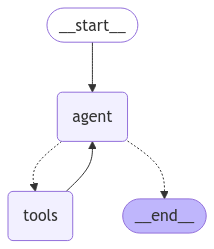

In [44]:
# Visualize the graph
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Step 10: Execute the graph

In [45]:
# Stream outputs from the graph as they pass through its nodes
def execute_graph(user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        user_input (str): User query string
    """
    # Add user input to the messages attribute of the graph state
    # The role of the message should be "user" and content should be `user_input`
    input = {"messages": [("user", user_input)]}
    # Pass input to the graph and stream the outputs
    for output in app.stream(input):
        for key, value in output.items():
            print(f"Node {key}:")
            print(value)
    print("---FINAL ANSWER---")
    print(value["messages"][-1].content)

In [46]:
# Test the graph execution to view end-to-end flow
execute_graph(
    "What are some best practices for data backups in MongoDB?"
#"What is MongoDB"
)

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 637, 'completion_tokens': 110, 'total_tokens': 747}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 637, 'completion_tokens': 110, 'total_tokens': 747}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-197abd38-b1f6-43b5-81e6-8780f46243cb-0', tool_calls=[{'name': 'get_information_for_question_answering', 'args': {'user_query': 'What are some best practices for data backups in MongoDB?'}, 'id': 'toolu_bdrk_01WRwGMe3MkVpctoASP4XLFR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 637, 'output_tokens': 110, 'total_tokens': 747})]}
Node tools:
{'messages': [ToolMessage(content="# Backup and Restore Sharded Clusters\n\nThe following tutorials describe backup and restoration for sharded clusters:\n\nTo use `mongodump` and `mongorestore` as a backup strategy for shar

In [47]:
# Test the graph execution to view end-to-end flow
execute_graph("Give me a summary of the page titled Create a MongoDB Deployment")

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 638, 'completion_tokens': 131, 'total_tokens': 769}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 638, 'completion_tokens': 131, 'total_tokens': 769}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-67e64bdf-92a9-43ba-b809-d5667f0b146f-0', tool_calls=[{'name': 'get_page_content_for_summarization', 'args': {'user_query': 'Create a MongoDB Deployment'}, 'id': 'toolu_bdrk_016WMtgc4n4D7WtpVtYXEiUa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 638, 'output_tokens': 131, 'total_tokens': 769})]}
Node tools:
{'messages': [ToolMessage(content="# Create a MongoDB Deployment\n\nYou can create a free tier MongoDB deployment on MongoDB Atlas to store and manage your data. MongoDB Atlas hosts and manages your MongoDB database in the cloud.\n\n## Create a Free MongoDB 

# Step 11: Add memory to the agent

In [48]:
from langgraph.checkpoint.mongodb import MongoDBSaver

In [49]:
# Initialize a MongoDB checkpointer
checkpointer = MongoDBSaver(mongodb_client)

In [50]:
# Instantiate the graph with the checkpointer
app = graph.compile(checkpointer=checkpointer)

📚 https://langchain-ai.github.io/langgraph/concepts/persistence/#threads

In [51]:
def execute_graph(thread_id: str, user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        thread_id (str): Thread ID for the checkpointer
        user_input (str): User query string
    """
    # Add user input to the messages attribute of the graph state
    # The role of the message should be "user" and content should be `user_input`
    input = {"messages": [("user", user_input)]}
    # Define a config containing the thread ID
    config = {"configurable": {"thread_id": thread_id}}
    # Pass `input` and `config` to the graph and stream outputs
    for output in app.stream(input, config):
        for key, value in output.items():
            print(f"Node {key}:")
            print(value)
    print("---FINAL ANSWER---")
    print(value["messages"][-1].content)

In [52]:
# Test graph execution with thread ID
execute_graph(
    "1",
    "What are some best practices for data backups in MongoDB?",
)

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 2406, 'completion_tokens': 101, 'total_tokens': 2507}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 2406, 'completion_tokens': 101, 'total_tokens': 2507}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-d1066985-5e21-42d0-992a-2a050496e08e-0', tool_calls=[{'name': 'get_information_for_question_answering', 'args': {'user_query': 'best practices for data backups in MongoDB'}, 'id': 'toolu_bdrk_01K2u7pQfBF9DXyp7u13uxVE', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2406, 'output_tokens': 101, 'total_tokens': 2507})]}
Node tools:
{'messages': [ToolMessage(content="# Backup and Restore Sharded Clusters\n\nThe following tutorials describe backup and restoration for sharded clusters:\n\nTo use `mongodump` and `mongorestore` as a backup strategy for sharded clust

In [53]:
# Follow-up question to ensure message history works
execute_graph(
    "1",
    "What did I just ask you?",
)

Node agent:
{'messages': [AIMessage(content='You just asked me: "What are some best practices for data backups in MongoDB?"', additional_kwargs={'usage': {'prompt_tokens': 3796, 'completion_tokens': 21, 'total_tokens': 3817}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 3796, 'completion_tokens': 21, 'total_tokens': 3817}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-e37878e6-b810-441f-99dd-0400d7ecbe69-0', usage_metadata={'input_tokens': 3796, 'output_tokens': 21, 'total_tokens': 3817})]}
---FINAL ANSWER---
You just asked me: "What are some best practices for data backups in MongoDB?"
